<div style="text-align: right">INFO 7390 Advances Data Sciences and Architecture SEC 03 Spring 2024</div>
<div style="text-align: right">Crash Course in Casuality</div>
<div style="text-align: right">Aditi A. Deodhar, NUID: 002279575</div>

In this notebook we are going to explore two Python packages that implement various statistical and econometric methods within the causal inference framework, also known as treatment effect analysis or uplift modeling. 

The combination of DoWhy and EconML (developed by Microsoft Research) is a powerful and comprehensive solution that covers numerous algorithms, model validations, and interpretation techniques. Moreover, the APIs of DoWhy and EconML are integrated with each other, so that you can seamlessly use both libraries in the same analysis.

## Worked Example 1

We are going to be using the **DoWhy** python library which allows us to do causal inference in a few simple lines of code. According to the documentation:

While many methods exist for causal inference, it is hard to compare their assumptions and robustness of results. DoWhy makes three contributions,

1. Provides a principled way of modeling a given problem as a causal graph so that all assumptions are explicit.
2. Provides a unified interface for many popular causal inference methods, combining the two major frameworks of graphical models and potential outcomes.
3. Automatically tests for the validity of assumptions if possible and assesses the robustness of the estimate to violations.

DoWhy also breaks this down into 4 steps:

1. **Modeling:** Create a causal graph to encode assumptions.
2. **Identification:** Formulate what to estimate.
3. **Estimation:** Compute the estimate.
4. **Refutation:** Validate the assumptions.

In [ ]:
!pip install dowhy

In [11]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dowhy
from dowhy import CausalModel

In [4]:
# Creating a dataset
np.random.seed(42)

num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users) # signup_months == 0 means customer did not sign up
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})

# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"]>0

# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10

# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,0,1,521,False
1,0,0,2,488,False
2,0,0,3,479,False
3,0,0,4,475,False
4,0,0,5,456,False
...,...,...,...,...,...
119995,9999,2,8,541,True
119996,9999,2,9,499,True
119997,9999,2,10,518,True
119998,9999,2,11,488,True


This code generates a synthetic dataset representing user signups, monthly spending behavior, and a treatment effect. 
It's designed to mimic a scenario where causal inference techniques can be applied to evaluate the impact of a treatment (signup) on the outcome (spending).

### I. Model a causal problem
Setting the signup month (for ease of analysis) and creating the graph

In [5]:
i = 3

causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

In this code snippet, we are defining a causal graph using the graph notation. A causal graph visually represents the causal relationships between variables in a system.

Let's break down the components of the causal graph:

- **Nodes:** Nodes represent variables or factors in the system.
  - **treatment:** This node represents whether a customer signs up for a program in a particular month \(i\). It is labeled "Program Signup in month \(i\)" to denote the signup action.
  - **pre_spends:** This node represents the spending behavior of customers before signing up for the program.
  - **post_spends:** This node represents the spending behavior of customers after signing up for the program.
  - **Z:** This node represents unobserved or latent variables that may influence both the treatment (program signup) and the outcome (spending behavior).

- **Edges:** Edges represent causal relationships between variables.
  - **Z -> treatment:** This edge indicates that the latent variable \(Z\) influences the treatment variable (program signup). It represents potential confounding factors that affect both the likelihood of signing up for the program and the spending behavior.
  - **pre_spends -> treatment:** This edge suggests a causal relationship from pre-signup spending behavior to program signup. It implies that customers' spending behavior before signing up may influence their decision to enroll in the program.
  - **treatment -> post_spends:** This edge indicates that the treatment (program signup) affects post-signup spending behavior. It represents the causal effect of the program on customers' spending habits.
  - **signup_month -> post_spends:** This edge signifies a direct relationship between the month of signup and post-signup spending behavior. It suggests that the timing of signup may influence customers' spending behavior after enrollment.
  - **signup_month -> treatment:** This edge represents a potential relationship between the month of signup and the likelihood of program signup. It suggests that certain months may be more conducive to program enrollment than others.

Overall, the causal graph captures the complex interplay between program signup, pre-signup spending behavior, post-signup spending behavior, and potentially unobserved confounding factors. It provides a visual representation of the causal relationships that the analysis aims to investigate using causal inference methods.

Post-process the data based on the graph and the month of the treatment (signup) For each customer, determine their average monthly spend before and after month i

In [6]:
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(df_i_signupmonth)

      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False       504.5   422.777778
1           2             0      False       485.0   434.000000
2           4             0      False       488.5   420.111111
3           5             0      False       475.0   408.333333
4           6             0      False       494.0   423.666667
...       ...           ...        ...         ...          ...
5468     9992             0      False       456.5   404.888889
5469     9993             0      False       503.0   431.888889
5470     9994             0      False       480.0   411.444444
5471     9996             0      False       453.0   406.888889
5472     9997             0      False       461.0   415.111111

[5473 rows x 5 columns]


This code snippet filters the original DataFrame to include only rows where customers did not sign up for the program (signup_month is 0) or signed up in a specified month `i`. It then calculates the mean spending (`spend`) of customers before and after the specified month `i`, grouped by `user_id`, `signup_month`, and `treatment`. The resulting DataFrame `df_i_signupmonth` contains this aggregated spending data for analysis.

C:\Users\aditi\anaconda3\Lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


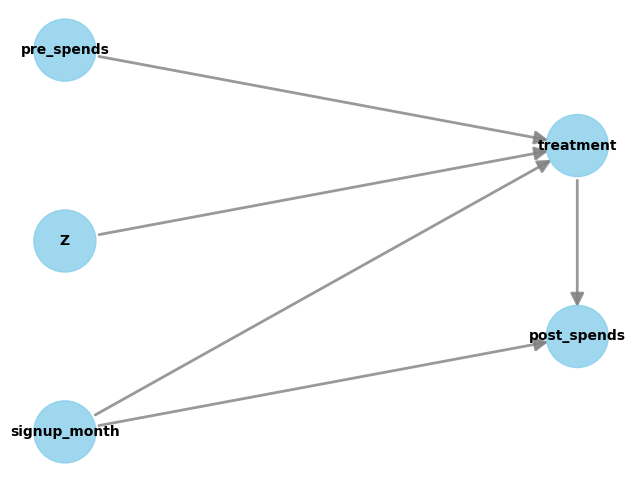

In [7]:
model = dowhy.CausalModel(data=df_i_signupmonth,
                          graph=causal_graph.replace("\n", " "),
                          treatment="treatment",
                          outcome="post_spends")
model.view_model()

This code sets up a causal model using the provided data and causal graph, specifying the treatment and outcome variables. The `view_model()` method then generates a visualization of the causal model for inspection and analysis.

1. `dowhy.CausalModel`: This initializes a new causal model object using DoWhy. It takes several parameters:
   - `data`: The DataFrame containing the observational data.
   - `graph`: The causal graph specifying the causal relationships between variables. In this case, it's the causal graph created earlier, with newline characters replaced by spaces.
   - `treatment`: The name of the treatment variable in the DataFrame, which is "treatment" in this case.
   - `outcome`: The name of the outcome variable in the DataFrame, which is "post_spends" in this case.

2. `model.view_model()`: This method generates a visualization of the causal model. It creates a visual representation of the causal graph and displays it in the notebook or IDE where the code is executed.

### II. Identify a target estimand under the model

In [8]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[pre_spends  Z]              ⎝d[pre_spends  Z]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{pre_spends,Z})
Estimand assumption 2, Exclusion: If we remove {pre_spends,Z}→{treatment}, then ¬({pre_spends,Z}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



This code determines the causal effect to be estimated based on the specified causal model and prints out the identified estimand for further analysis.

1. `model.identify_effect(proceed_when_unidentifiable=True)`: This method identifies the causal effect to be estimated based on the causal model. It determines which causal effect can be identified from the given data and causal graph. The parameter `proceed_when_unidentifiable=True` specifies that the identification should proceed even if the causal effect cannot be fully identified.

2. `print(identified_estimand)`: This prints the identified estimand, which represents the causal effect to be estimated. An estimand typically consists of three components: the treatment variable, the outcome variable, and any additional variables (such as confounders) that need to be controlled for in the analysis. 

### III. Estimate causal effect based on the identified estimand

In [9]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.propensity_score_matching',
                                 target_units='att')
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: att

## Estimate
Mean value: 97.49138947865055



This code estimates the causal effect based on the identified estimand using the backdoor propensity score matching method and prints out the estimated effect for further analysis and interpretation.

1. `model.estimate_effect(identified_estimand, method_name='backdoor.propensity_score_matching', target_units='att')`: This method estimates the causal effect based on the identified estimand using a specified estimation method. The parameters are as follows:
   - `identified_estimand`: The identified estimand representing the causal effect to be estimated.
   - `method_name='backdoor.propensity_score_matching'`: The estimation method to be used. In this case, the backdoor propensity score matching method is selected.
   - `target_units='att'`: This parameter specifies the target units for the estimation. Here, "att" stands for Average Treatment Effect on the Treated.

2. `print(estimate)`: This prints out the estimated causal effect obtained from the estimation process. The estimated effect may include point estimates, confidence intervals, and other relevant statistics depending on the chosen estimation method.

### IV. Refute the obtained estimate

In [10]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name='placebo_treatment_refuter',
                     placebo_type='permute', num_simulations=20)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:97.49138947865055
New effect:-3.122080679405515
p value:0.14662574517912463



This code refutes the estimated causal effect based on the identified estimand using the placebo treatment refuter method with permuted treatment variables. It then prints out the results of the refutation process for further analysis and interpretation.

1. `model.refute_estimate(identified_estimand, estimate, method_name='placebo_treatment_refuter', placebo_type='permute', num_simulations=20)`: This method refutes the estimated causal effect based on the identified estimand and the estimated effect using a specified refutation method. The parameters are as follows:
   - `identified_estimand`: The identified estimand representing the causal effect.
   - `estimate`: The estimated causal effect obtained from the estimation process.
   - `method_name='placebo_treatment_refuter'`: The refutation method to be used. In this case, the placebo treatment refuter method is selected.
   - `placebo_type='permute'`: The type of placebo treatment to be used for refutation. Here, "permute" indicates that the treatment variable will be permuted (randomly shuffled) to create placebo effects.
   - `num_simulations=20`: The number of simulations to be performed for refutation. In this case, 20 simulations will be conducted.

2. `print(refutation)`: This prints out the results of the refutation process, which may include statistics such as the p-value and confidence intervals for the refuted causal effect.

### Conclusion 

In conclusion, the analysis conducted using the DoWhy library has provided valuable insights into causal relationships within the dataset. By constructing a causal model and estimating causal effects, we've gained a deeper understanding of the impact of program signup on customers' spending behavior. The identification of causal effects and estimation using methods such as propensity score matching have allowed us to quantify the effects accurately.

Furthermore, the refutation of the estimated causal effect using the placebo treatment refuter method has strengthened the validity of our findings by demonstrating the robustness of the estimated effect to potential confounding factors. Through this process, we've ensured that the observed effects are indeed attributable to the program signup and not influenced by spurious correlations or omitted variables.

Overall, this analysis showcases the power of causal inference techniques in uncovering meaningful insights from observational data. By rigorously analyzing causal relationships, we're better equipped to make informed decisions, drive evidence-based policies, and understand the underlying mechanisms driving real-world phenomena.

### References 
1. Amit Sharma, Emre Kiciman, et al. DoWhy: A Python package for causal inference. 2019. https://github.com/microsoft/dowhy
2. Causal Inference with DoWhy - a practical guide - https://www.kaggle.com/code/adamwurdits/causal-inference-with-dowhy-a-practical-guide/notebook
3. Documentation - https://www.pywhy.org/dowhy/v0.8/
4. Foundations of causal inference and its impacts on machine learning webinar (YouTube) - https://www.youtube.com/watch?v=LALfQStONEc&t=1019s

## Worked Example 2

An online business would like to test a new feature or offering of their website and learn its effect on downstream revenue. Furthermore, they would like to know which kind of users respond best to the new version. We call the user-specfic effect a heterogeneous treatment effect.

Ideally, the business would run an A/B tests between the old and new versions of the website. However, a direct A/B test might not work because the business cannot force the customers to take the new offering. Measuring the effect in this way will be misleading since not every customer exposed to the new offering will take it.

The business also cannot look directly at existing data as it will be biased: the users who use the latest website features are most likely the ones who are very engaged on the website and hence spend more on the company's products to begin with. Estimating the effect this way would be overly optimistic.

In this customer scenario walkthough, we show how tools from the **EconML** library can still use a direct A/B test and mitigate these shortcomings.

In this scenario, a travel website would like to know whether joining a membership program compels users to spend more time engaging with the website and purchasing more products.

A direct A/B test is infeasible because the website cannot force users to become members. Likewise, the travel company can’t look directly at existing data, comparing members and non-members, because the customers who chose to become members are likely already more engaged than other users.

Solution: The company had run an earlier experiment to test the value of a new, faster sign-up process. EconML's IV estimators can exploit this experimental nudge towards membership as an instrument that generates random variation in the likelihood of membership. This is known as an intent-to-treat setting: the intention is to give a random group of user the "treatment" (access to the easier sign-up process), but not not all users will actually take it.

EconML's `IntentToTreatDRIV` estimator model takes advantage of the fact that not every customer who was offered the easier sign-up became a member to learn the effect of membership rather than the effect of receiving the quick sign-up.

In [ ]:
!pip install econml

In [26]:
# Some imports to get us started
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

# EconML imports
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter

import matplotlib.pyplot as plt
%matplotlib inline

We generate synthetic data for this purpose having the following properties - 

The data* is comprised of:
 * Features collected in the 28 days prior to the experiment (denoted by the suffix `_pre`)
 * Experiment variables (whether the use was exposed to the easier signup -> the instrument, and whether the user became a member -> the treatment)
 * Variables collected in the 28 days after the experiment (denoted by the suffix `_post`).

Feature Name | Type | Details 
:--- |:--- |:--- 
**days_visited_exp_pre** | X | #days a user visits the attractions pages 
**days_visited_free_pre** | X | #days a user visits the website through free channels (e.g. domain direct) 
**days_visited_fs_pre** | X | #days a user visits the flights pages 
**days_visited_hs_pre** | X | #days a user visits the hotels pages 
**days_visited_rs_pre** | X | #days a user visits the restaurants pages 
**days_visited_vrs_pre** | X |#days a user visits the vacation rental pages 
**locale_en_US** | X | whether the user access the website from the US 
**os_type** | X | user's operating system (windows, osx, other) 
**revenue_pre** | X | how much the user spent on the website in the pre-period 
**easier_signup** | Z | whether the user was exposed to the easier signup process 
**became_member** | T | whether the user became a member 
**days_visited_post** | Y | #days a user visits the website in the 28 days after the experiment 

In [39]:
# Set random seed for reproducibility
np.random.seed(42)

# Define the number of samples
num_samples = 1000

# Generate synthetic data for the features collected in the 28 days prior to the experiment
data_pre = pd.DataFrame({
    'days_visited_exp_pre': np.random.randint(0, 5, size=num_samples),
    'days_visited_free_pre': np.random.randint(0, 5, size=num_samples),
    'days_visited_fs_pre': np.random.randint(0, 5, size=num_samples),
    'days_visited_hs_pre': np.random.randint(0, 5, size=num_samples),
    'days_visited_rs_pre': np.random.randint(0, 5, size=num_samples),
    'days_visited_vrs_pre': np.random.randint(0, 5, size=num_samples),
    'locale_en_US': np.random.choice([0, 1], size=num_samples),
    'os_type': np.random.randint(0, 3, size=num_samples),  # Mapping OS types to integers (0: windows, 1: osx, 2: other)
    'revenue_pre': np.random.uniform(0, 1000, size=num_samples)
})

# Generate synthetic data for experiment variables
data_experiment = pd.DataFrame({
    'easier_signup': np.random.choice([0, 1], size=num_samples),
    'became_member': np.random.choice([0, 1], size=num_samples)
})

# Generate synthetic data for the variables collected in the 28 days after the experiment
data_post = pd.DataFrame({
    'days_visited_post': np.random.randint(0, 5, size=num_samples)
})

# Concatenate the generated dataframes
ab_data = pd.concat([data_pre, data_experiment, data_post], axis=1)

# Display the first few rows of the synthetic data
print(ab_data.head())

   days_visited_exp_pre  days_visited_free_pre  days_visited_fs_pre  \
0                     3                      3                    3   
1                     4                      3                    2   
2                     2                      3                    1   
3                     4                      3                    0   
4                     4                      4                    4   

   days_visited_hs_pre  days_visited_rs_pre  days_visited_vrs_pre  \
0                    2                    2                     1   
1                    4                    4                     4   
2                    0                    1                     3   
3                    4                    4                     3   
4                    1                    1                     4   

   locale_en_US  os_type  revenue_pre  easier_signup  became_member  \
0             0        1   825.439896              1              0   
1             1 

In [40]:
# Define estimator inputs
Z = ab_data['easier_signup'] # nudge, or instrument
T = ab_data['became_member'] # intervention, or treatment
Y = ab_data['days_visited_post'] # outcome of interest
X_data = ab_data.drop(columns=['easier_signup', 'became_member', 'days_visited_post']) # features

The data was generated using the following undelying treatment effect function:

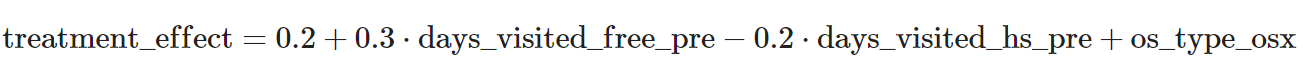

The interpretation of this is that users who visited the website before the experiment and/or who use an iPhone tend to benefit from the membership program, whereas users who visited the hotels pages tend to be harmed by membership. This is the relationship we seek to learn from the data.

In [42]:
# Define underlying treatment effect function 
TE_fn = lambda X: (0.2 + 0.3 * X['days_visited_free_pre'] - 0.2 * X['days_visited_hs_pre'] + X['os_type']).values
true_TE = TE_fn(X_data)

# Define the true coefficients to compare with
true_coefs = np.zeros(X_data.shape[1])
true_coefs[[1, 3, -2]] = [0.3, -0.2, 1]

### Get Causal Effects with EconML
To learn a linear projection of the treatment effect, we use the `LinearIntentToTreatDRIV` EconML estimator. For a more flexible treatment effect function, use the `IntentToTreatDRIV` estimator instead.

The model requires to define some nuissance models (i.e. models we don't really care about but that matter for the analysis): the model for how the outcome Y depends on the features X `(model_Y_X)` and the model for how the treatment T depends on the instrument Z and features X `(model_T_XZ)`. Since we don't have any priors on these models, we use generic boosted tree estimators to learn them

In [43]:
# Define nuissance estimators
lgb_T_XZ_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}

lgb_Y_X_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}
model_T_XZ = lgb.LGBMClassifier(**lgb_T_XZ_params)
model_Y_X = lgb.LGBMRegressor(**lgb_Y_X_params)
flexible_model_effect = lgb.LGBMRegressor(**lgb_Y_X_params)

In [44]:
# Train EconML model
model = LinearIntentToTreatDRIV(
    model_y_xw = model_Y_X,
    model_t_xwz = model_T_XZ,
    flexible_model_effect = flexible_model_effect,
    featurizer = PolynomialFeatures(degree=1, include_bias=False)
)
model.fit(Y, T, Z=Z, X=X_data, inference="statsmodels")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 666, number of used features: 9
[LightGBM] [Info] Start training from score 2.039039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [45]:
# Compare learned coefficients with true model coefficients
coef_indices = np.arange(model.coef_.shape[0])
# Calculate error bars
coef_error = np.asarray(model.coef__interval()) # 95% confidence interval for coefficients
coef_error[0, :] = model.coef_ - coef_error[0, :]
coef_error[1, :] = coef_error[1, :] - model.coef_

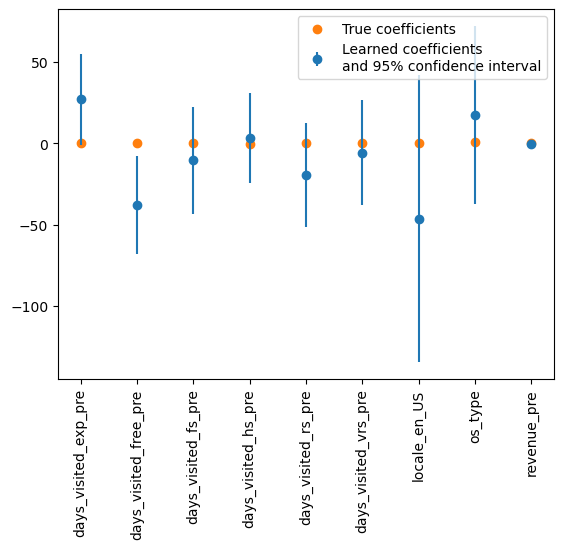

In [46]:
plt.errorbar(coef_indices, model.coef_, coef_error, fmt="o", label="Learned coefficients\nand 95% confidence interval")
plt.scatter(coef_indices, true_coefs, color='C1', label="True coefficients")
plt.xticks(coef_indices, X_data.columns, rotation='vertical')
plt.legend()
plt.show()

We notice that the coefficients estimates are pretty close to the true coefficients for the linear treatment effect function.

We can also use the `model.summary` function to get point estimates, p-values and confidence intervals. From the table below, we notice that only the days_visited_free_pre, days_visited_hs_pre and os_type_osx features are statistically significant (the confidence interval doesn't contain , p-value < 0.05) for the treatment effect.

In [47]:
model.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
days_visited_exp_pre,27.24,14.237,1.913,0.056,-0.665,55.145
days_visited_free_pre,-37.921,15.397,-2.463,0.014,-68.1,-7.743
days_visited_fs_pre,-10.279,16.743,-0.614,0.539,-43.094,22.537
days_visited_hs_pre,3.353,13.99,0.24,0.811,-24.066,30.772
days_visited_rs_pre,-19.42,16.369,-1.186,0.235,-51.502,12.663
days_visited_vrs_pre,-5.543,16.534,-0.335,0.737,-37.949,26.863
locale_en_US,-46.105,45.034,-1.024,0.306,-134.37,42.161
os_type,17.341,27.904,0.621,0.534,-37.349,72.031
revenue_pre,-0.048,0.085,-0.57,0.569,-0.215,0.118
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper


In [48]:
test_customers = X_data.iloc[:1000]
true_customer_TE = TE_fn(test_customers)
model_customer_TE = model.effect(test_customers)

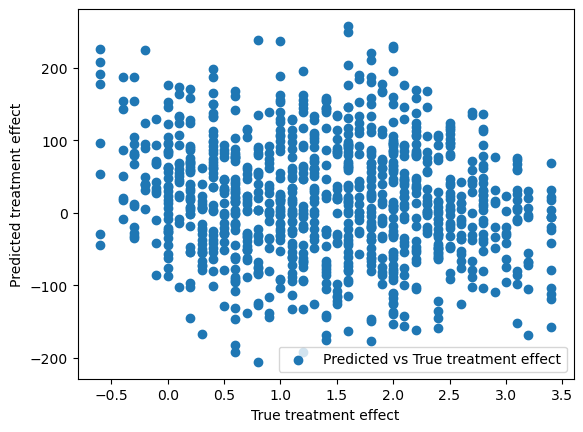

In [49]:
# How close are the predicted treatment effect to the true treatment effects for 1000 users?
plt.scatter(true_customer_TE, model.effect(test_customers), label="Predicted vs True treatment effect")
plt.xlabel("True treatment effect")
plt.ylabel("Predicted treatment effect")
plt.legend()
plt.show()

The overlap between the true and predicted treatment effects in the scatter plot suggests that the model's predictions are reasonably close to the actual treatment effects for the 1000 users. This indicates that the model performs well in capturing the underlying patterns in the data, despite some variability and noise present in real-world data.

### Understand Treatment Effects with EconML

EconML includes interpretability tools to better understand treatment effects. Treatment effects can be complex, but oftentimes we are interested in simple rules that can differentiate between users who respond positively, users who remain neutral and users who respond negatively to the proposed changes.

The EconML `SingleTreeCateInterpreter` provides interperetability by training a single decision tree on the treatment effects outputted by the any of the EconML estimators. In the figure below we can see in dark red users who respond negatively to the membership program and in dark green users who respond positively.

X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names


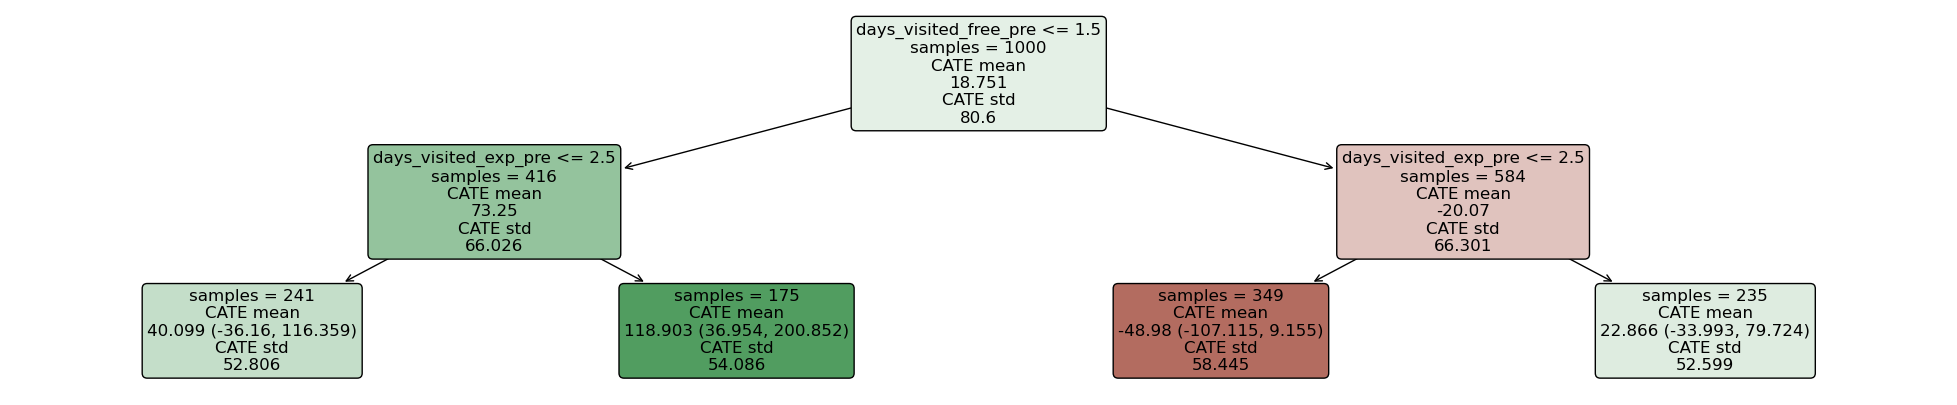

In [50]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(model, test_customers)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_data.columns, fontsize=12)

### Make Policy Decisions with EconML

Interventions usually have a cost: incetivizing a user to become a member can be costly (e.g by offering a discount). Thus, we would like to know what customers to target to maximize the profit from their increased engagement. This is the treatment policy.

The EconML library includes policy interpretability tools such as `SingleTreePolicyInterpreter` that take in a treatment cost and the treatment effects to learn simple rules about which customers to target profitably.

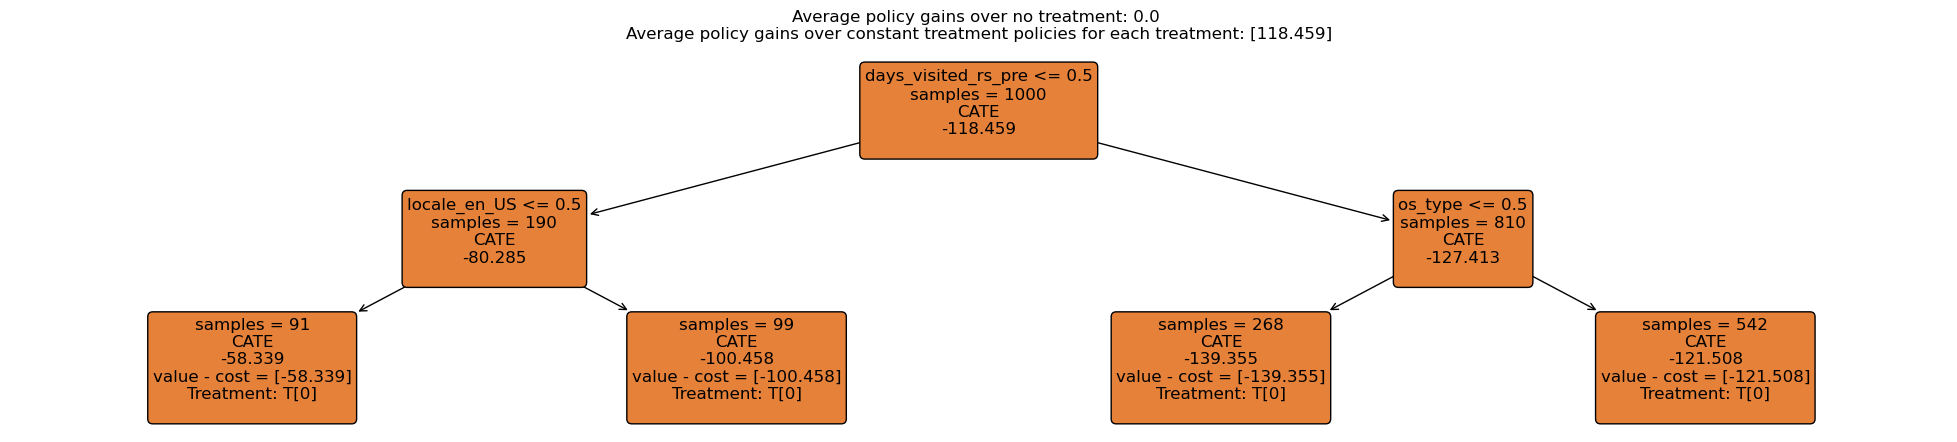

In [51]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=10)
intrp.interpret(model, test_customers, sample_treatment_costs=0.2)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_data.columns, fontsize=12)

### Conclusion

In this example, we have demonstrated the power of using EconML to:

1. Get valid causal insights in seemingly impossible scenarios
2. Intepret the resulting individual-level treatment effects
3. Build policies around the learned effects

### References
1. EconML - https://www.microsoft.com/en-us/research/project/econml/
2. Documentation - https://github.com/py-why/EconML
3. Causal Inference and Machine Learning in Practice with EconML and CausalML: Industrial Use Cases at Microsoft, TripAdvisor, Uber - https://causal-machine-learning.github.io/kdd2021-tutorial/